In [21]:
from sklearn.ensemble import RandomForestClassifier
import joblib
import numpy as np
import pickle
import matplotlib.pyplot as plt
import pandas as pd

In [6]:
import os
os.getcwd()

'/home/student'

<h1> Model Feature Importance </h1>

<AxesSubplot:ylabel='Feature'>

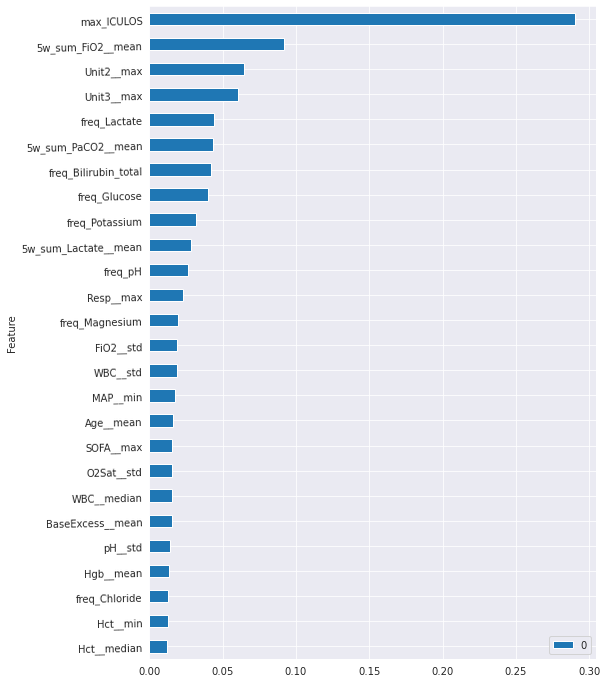

In [43]:
RFmodel = joblib.load('/home/student/Early_Prediction_of_Sepsis/RF_best1405')
with open(f'/home/student/Early_Prediction_of_Sepsis/Best_features_RF_run2.pickle', 'rb') as handle:
    RFfeature_names = pickle.load(handle)
RF_tree_feature_importances = pd.DataFrame(RFmodel.feature_importances_)
res =RF_tree_feature_importances.join(pd.DataFrame({'Feature':RFfeature_names}))
res.sort_values(by=0).plot.barh(x='Feature',y=0,rot=1,figsize=(8,12))

<AxesSubplot:ylabel='Feature'>

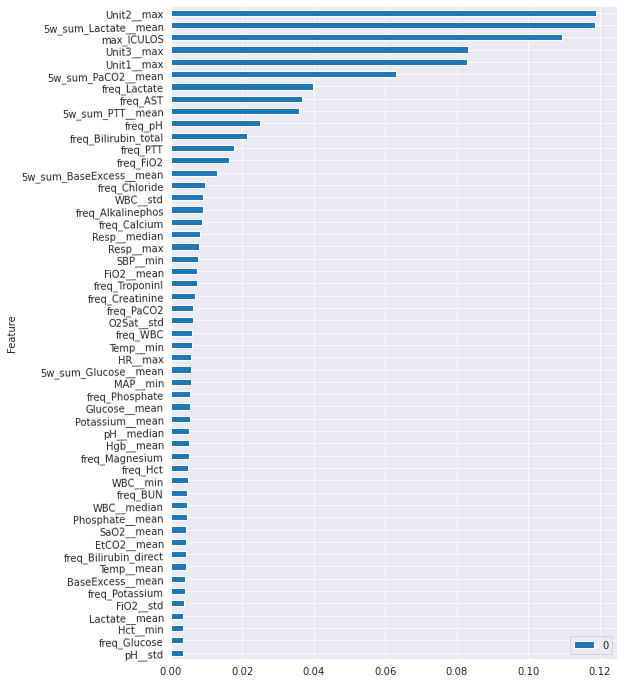

In [41]:
XGBmodel = joblib.load('/home/student/Early_Prediction_of_Sepsis/best_XGB_53')
with open(f'/home/student/Early_Prediction_of_Sepsis/Best_features_XGB_run.pickle', 'rb') as handle:
    XGB_feature_names = pickle.load(handle)
XGB_feature_names=XGB_feature_names[:53]
XGB_tree_feature_importances = pd.DataFrame(XGBmodel.feature_importances_)
res =XGB_tree_feature_importances.join(pd.DataFrame({'Feature':XGB_feature_names}))
res.sort_values(by=0).plot.barh(x='Feature',y=0,rot=1,figsize=(8,12))

<h1> SHAP </h1>

In [1]:
import shap
import torch
from LSTM_Model import RNN_Model, Dataset, collate_inputs
from torch.utils.data import DataLoader
import pandas as pd

In [2]:
model = RNN_Model(rnn_type='GRU', bidirectional=False, input_dim=35,
                  hidden_dim=256, dropout=0.3922844934594849 , num_layers=3)
model.load_state_dict(torch.load('Trained Models/astral_sweep.pth')['model_state'])

#initialize js methods for visualization
shap.initjs()

val_df = pd.read_csv('/home/student/filtered_val_df_0705_LSTM_new.csv')
test_patients = list(set(val_df.ID.values))
cols = list(val_df.columns)
cols.remove('Label')
cols.remove('ID')
ds = Dataset(test_patients, val_df, cols)
dl = DataLoader(ds, batch_size=len(test_patients), collate_fn=collate_inputs)

batch = next(iter(dl))
batch_input, batch_target, lengths, mask, batch_ids = batch

In [3]:
# create an instance of the DeepSHAP which is called DeepExplainer
explainer_shap= shap.DeepExplainer(model,data=[batch_input,lengths,mask])

In [4]:
shap_values = explainer_shap.shap_values([batch_input,lengths.to(torch.float64),mask.to(torch.float64)])

Using non-full backward hooks on a Module that does not return a single Tensor or a tuple of Tensors is deprecated and will be removed in future versions. This hook will be missing some of the grad_output. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


RuntimeError: Subtraction, the `-` operator, with a bool tensor is not supported. If you are trying to invert a mask, use the `~` or `logical_not()` operator instead.

In [ ]:
shap.summary_plot(shap_values, [batch_input,lengths,mask], class_names=['No Sepsis','Sepsis'])

In [5]:
model.feature_importances_

AttributeError: 'RNN_Model' object has no attribute 'feature_importances_'

<h1> LIME </h1>

In [7]:
import shap
import torch
from LSTM_Model import RNN_Model, Dataset, collate_inputs
from torch.utils.data import DataLoader
import pandas as pd

In [9]:
model = RNN_Model(rnn_type='GRU', bidirectional=False, input_dim=35,
                  hidden_dim=256, dropout=0.3922844934594849 , num_layers=3)
model.load_state_dict(torch.load('Trained Models/astral_sweep.pth')['model_state'])

#initialize js methods for visualization
shap.initjs()

val_df = pd.read_csv('/home/student/filtered_val_df_0705_LSTM_new.csv')
test_patients = list(set(val_df.ID.values))
cols = list(val_df.columns)
cols.remove('Label')
cols.remove('ID')
ds = Dataset(test_patients, val_df, cols)
dl = DataLoader(ds, batch_size=len(test_patients), collate_fn=collate_inputs)

batch_input, batch_target, lengths, mask, batch_ids = batch = next(iter(dl))

In [43]:
import lime
import lime.lime_tabular
import numpy as np
class_names=['negative','positive']
lime_explainer = lime.lime_tabular.LimeTabularExplainer(val_df[cols].to_numpy(),
                                                        feature_names=cols,
                                                        class_names=class_names,
                                                        discretize_continuous=True)

In [41]:
# predictions = model(batch_input, lengths, mask)


AttributeError: 'Tensor' object has no attribute 'copy'

In [44]:
lime_explainer.explain_instance(np.array(batch_input[0]),).show_in_notebook(text=True)

ValueError: could not broadcast input array from shape (11,35) into shape (11,)